In [2]:
import numpy as np
from numpy import random
from random import choices
import matplotlib.pyplot as plt
import levy
# import plotly.express as px

In [3]:
class Stimuli:
    def __init__(self,mu,dev):
        self.mu = mu
        self.dev = dev
    def sample(self):
        return random.normal(self.mu, self.dev)      # random sample from distribution of sample

def exploit(candidates,total_time):
    scores = [c.sample() for c in candidates]
    chosen = candidates[np.argmax(scores)]
    for t in range(len(candidates),total_time):
        scores.append(chosen.sample())
    return sum(scores)

def ucb1(candidates, total_time):
    scores = []                # Initialise scores
    history = {idx: [c.sample()] for idx,c in enumerate(candidates)}   # Init history then sample each option once.
    chosen_history = [i for i,c in enumerate(candidates)]
    for t in range(len(candidates),total_time):
        # Find action + upper confidence bound for each candidate
        mu_plus_ucb = [np.mean(history[idx])+np.sqrt(2*np.log(t)/len(history[idx])) for idx in range(len(candidates))]
        chosen = candidates[np.argmax(mu_plus_ucb)]     # Find candidate with highest value
        score = chosen.sample()                         # Sample from candidate distribution   
        scores.append(score)                            # Add to score list
        history[candidates.index(chosen)].append(score) # Update history 
        chosen_history.append(candidates.index(chosen))
    return sum(scores), chosen_history

def softmax(candidates,total_time):
    scores = []
    history = {idx: [c.sample()] for idx,c in enumerate(candidates)}        # sample each option once
    chosen_history = [i for i,c in enumerate(candidates)]
    for t in range(len(candidates), total_time): 
        expected_rewards = [np.mean(history[item]) for item in history]                           # overall reward
        weights = np.exp(expected_rewards)/np.sum(np.exp(expected_rewards)) # probability vector
        chosen = choices(candidates,weights)     # choose from candidates with ^ weights
        score = chosen[0].sample()              # returned as [element]
        scores.append(score)
        history[candidates.index(chosen[0])].append(score)
        chosen_history.append(candidates.index(chosen[0]))
    return sum(scores), chosen_history

def logistic_noise(candidates,total_time,sigma):  # Should specify the noise separately
    scores = []
    history = {idx: [c.sample()] for idx,c in enumerate(candidates)}
    chosen_history = [i for i,c in enumerate(candidates)]
    for t in range(len(candidates), total_time):
        expected_rewards = [np.mean(history[item]) for item in history]
        std_rewards = [np.std(history[item]) for item in history]
        noisy_rewards = random.logistic(expected_rewards, scale = sigma)  # what scale and shape?
        chosen = candidates[np.argmax(noisy_rewards)]
        score = chosen.sample()
        scores.append(score)
        history[candidates.index(chosen)].append(score)
        chosen_history.append(candidates.index(chosen))
    return sum(scores), chosen_history

def levy_noise(candidates,total_time,alpha,sig):  # Consider pregenerating noise
    scores = []
    history = {idx: [c.sample()] for idx,c in enumerate(candidates)}    # Initialise history and sample options once
    chosen_history = [i for i,c in enumerate(candidates)]
    levy_noise = levy.random(alpha=alpha,beta=0,mu=0,sigma=sig,shape=(len(candidates),total_time))
    for t in range(len(candidates), total_time):
        expected_rewards = [np.mean(history[item]) for item in history]
        noisy_rewards = expected_rewards + levy_noise[:,t]
        chosen = candidates[np.argmax(noisy_rewards)]
        score = chosen.sample()
        scores.append(score)
        history[candidates.index(chosen)].append(score)
        chosen_history.append(candidates.index(chosen))

    return sum(scores), chosen_history

def mean_regret(optimal_average,vals):
    regret = (optimal_average - np.mean(vals)) / optimal_average

0
1
2


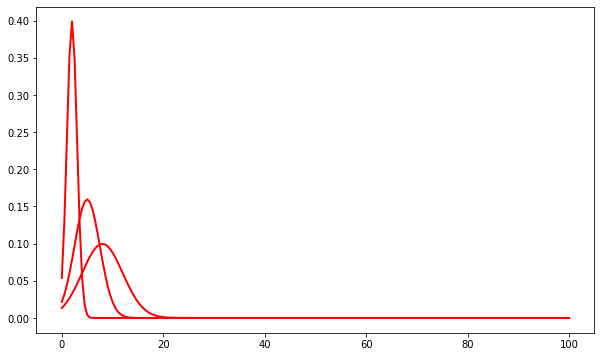

In [5]:
# Initialising multi-armed bandit problem
num_cand = 3
var = 0.5
mu_vals = [2+3*i for i in range(num_cand)]      # consider changing setup to overlapping distributions (50/50 prob)
sig_vals = [mu*var for mu in mu_vals]

# mu_vals = [20 + 10*i for i in range(num_cand)] 
# sig_vals = [5 for i in range(num_cand)]
# mu_vals = [3,4,5]
# sig_vals = np.array([5,4,3])/2

mu_sig = zip(mu_vals,sig_vals)
candidates = [Stimuli(mu,sigma) for mu,sigma in mu_sig]
total_time = 500
optimal_average = max(mu_vals)*total_time       # consider changing to sampling from max mu option
num_avg = 100

fig,ax = plt.subplots(figsize=(10,6))
bins = np.linspace(0,100,200)
for i in range(0,len(mu_vals)):
    plt.plot(bins, 1/(sig_vals[i] * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu_vals[i])**2 / (2 * sig_vals[i]**2) ),
         linewidth=2, color='r')
    print(i)



In [6]:
exploit_vals = []
for _ in range(1000):         # Number of averages
    val = exploit(candidates,total_time)
    exploit_vals.append(val)
print('Exploit Mean Regret: %s'%((optimal_average - np.mean(exploit_vals)) / optimal_average))

ucb1_vals = []
for _ in range(1000):
    [val,history] = ucb1(candidates,total_time)
    ucb1_vals.append(val)
print('UCB1 Mean Regret: %s'%((optimal_average - np.mean(ucb1_vals)) / optimal_average))
# print(np.mean(ucb1_vals)/total_time)

softmax_vals = []
for _ in range(1000):         # Number of averages
    [val,history] = softmax(candidates,total_time)
    softmax_vals.append(val)
print('Softmax Mean Regret: %s'%((optimal_average - np.mean(softmax_vals)) / optimal_average))

logistic_vals = []
for _ in range(1000):         # Number of averages
    [val,history] = logistic_noise(candidates,total_time,0.3)
    logistic_vals.append(val)
print('Logistic Noise Mean Regret: %s'%((optimal_average - np.mean(logistic_vals)) / optimal_average))


Exploit Mean Regret: 0.0960885227778565
UCB1 Mean Regret: 0.036363284945382816
Softmax Mean Regret: 0.03676027823870766
Logistic Noise Mean Regret: 0.04686495717365596


In [7]:
levy_vals = []
for _ in range(1000):         # Number of averages
    [val,history] = levy_noise(candidates,total_time,1.4,0.3)
    levy_vals.append(val)
mean_regret = (optimal_average - np.mean(levy_vals)) / optimal_average
print('Levy Noise Mean Regret: %s'% round(mean_regret,4))

Levy Noise Mean Regret: 0.0398


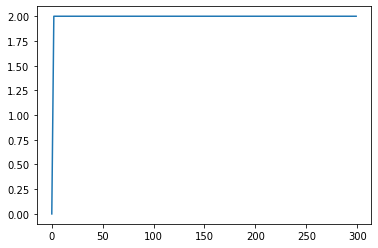

In [112]:
[_, history] = ucb1(candidates,total_time)
plt.plot(history)

# print(np.exp(mu_vals)/np.sum(np.exp(mu_vals)))
# print(((optimal_average - np.array(levy_vals)) / optimal_average))